# Lab - Dogs vs Cats

Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.

I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

## Uppgifter
Dokumentera i markdown i Jupyter notebook eller i separat markdownfil om du använder Pythonskript.

### 0. EDA och filhantering (*)

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pickle

#### c) Skapa folderstrukturen med Python

In [50]:
#for size in ["small", "tiny"]:
#    os.mkdir(f"experiment_{size}_data")
#    for dataset in ["test", "train", "val"]:
#        os.mkdir(f"experiment_{size}_data/{dataset}")

#os.rename("Pictures_of_dogs_and_cats", "original_data")

#### a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [13]:
def plot_random_sample(number_of_samples:int) -> None:
    """
    Plots a random sample of images from the original Dogs vs Cats data.
    Plots five pictures per row.
    
    Parameters
    ----------
    number_of_samples : int
        The number of images to be plotted.
        Preferably the chosen number should be evenly divided by 5,
        so that all rows will be filled.
        
    
    Returns
    -------
    None
    """

    # Initialise variables
    labels = [random.choice(["cat", "dog"]) for i in range(number_of_samples)]
    numbers = random.sample(range(12500), number_of_samples)
    images = []

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples//5)+1)

    # Read the images and save the labels
    for label, number in zip(labels, numbers):
        images.append(plt.imread(f"original_data/train/{label}.{number}.jpg"))
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    for i, ax, label in zip(range(number_of_samples), axes.flatten(), labels):
        ax.imshow(images[i]) 
        ax.axis("off")
        if label == "cat":
            ax.set(title="Cat: 0")
        else:
            ax.set(title="Dog: 1")

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

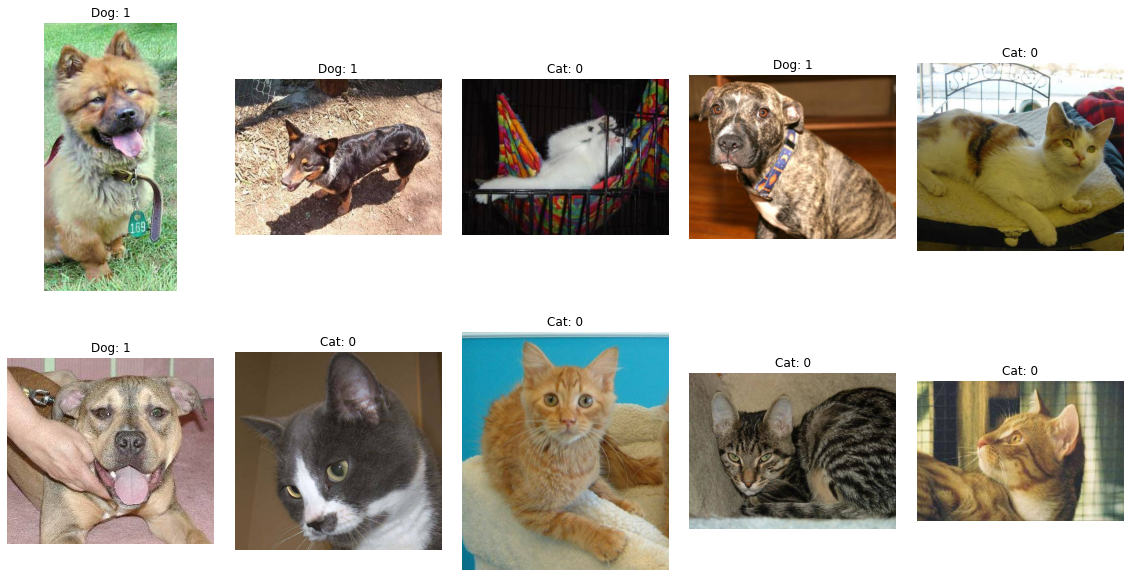

In [64]:
plot_random_sample(10)

#### d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

Det är inte så farligt om det inte blir exakt balanserade dataset.

Det är viktigt att du samplar slumpmässigt utan replacement från originaldatasetet under respektive
experiment. Spara datan i deras respektive mappar. (**)

In [117]:
# Saves all file names in the original data in a dataframe
img_names = pd.DataFrame({"file_name" : os.listdir("original_data/train")})

# Creates cat column with True if the file name contains cat and False if the file name contains dog
img_names["cat"] = img_names["file_name"].str.contains("cat") 

cats = img_names[img_names["cat"] == True]
dogs = img_names[img_names["cat"] == False]
len(cats), len(dogs)

(12500, 12500)

In [120]:
def train_val_test_split(data1:pd.Series, data2:pd.Series, train_size:int, val_size:int, test_size:int) -> tuple[list, list, list]:
    """
    Takes equally sized, random samples from two datasets,
    and splits them into training, validation and test data. 
    
    Parameters
    ----------
    data1 : pd.Series
        The file names in dataset 1
    data2 : pd.Series
        The file names in dataset 2
    train_size : int
        Size of training data 
    val_size : int
        Size of validation data 
    test_size : int
        Size of test data 
    
    Returns
    -------
    tuple[list, list, list]:
        A tuple of training, validation and test data 
    """

    # Half size for each dataset
    train_size = int(train_size/2)
    val_size = int(val_size/2)
    test_size = int(test_size/2)

    # Picks out a full sample 
    full_sample_size = train_size + val_size + test_size
    data1_full_sample = random.sample(list(data1), full_sample_size)
    data2_full_sample = random.sample(list(data2), full_sample_size)

    # Creates random training sample from the full sample and merge dataset 1 and 2
    data1_train = random.sample(data1_full_sample, train_size)
    data2_train = random.sample(data2_full_sample, train_size)
    train = data1_train + data2_train

    # Creates random validation sample from the data not used for training  and merge dataset 1 and 2
    data1_val = random.sample(list(set(data1_full_sample) - set(data1_train)), val_size) #Reference: https://stackoverflow.com/questions/41125909/python-find-elements-in-one-list-that-are-not-in-the-other
    data2_val = random.sample(list(set(data2_full_sample) - set(data2_train)), val_size)
    val = data1_val + data2_val

    # Creates random test sample from the data not used for training or validation and merge dataset 1 and 2
    data1_test = random.sample(list(set(data1_full_sample) - set(data1_train) - set(data1_val)), test_size)
    data2_test = random.sample(list(set(data2_full_sample) - set(data2_train) - set(data2_val)), test_size)
    test = data1_test + data2_test

    return train, val, test

In [121]:
train_small, val_small, test_small = train_val_test_split(cats["file_name"], dogs["file_name"], 1600, 400, 500)
train_tiny, val_tiny, test_tiny = train_val_test_split(cats["file_name"], dogs["file_name"], 160, 40, 50)

In [51]:
print(f"{len(set(train_small))} out of a total of {len(train_small)} training samples are unique.")
print(f"{len(set(val_small))} out of a total of {len(val_small)} validation samples are unique.")
print(f"{len(set(test_small))} out of a total of {len(test_small)} test samples are unique.")

print(f"Any image both in validation and training data? {any(sample in val_small for sample in train_small)}")
print(f"Any image both in test and training data? {any(sample in test_small for sample in train_small)}")
print(f"Any image both in validation and test data? {any(sample in val_small for sample in test_small)}")

1600 out of a total of 1600 training samples are unique.
400 out of a total of 400 validation samples are unique.
500 out of a total of 500 test samples are unique.
Any image both in validation and training data? False
Any image both in test and training data? False
Any image both in validation and test data? False


In [69]:
#for data, folder in zip([train_tiny, val_tiny, test_tiny], ["train", "val", "test"]):
    
#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_tiny_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

In [70]:
#for data, folder in zip([train_small, val_small, test_small], ["train", "val", "test"]):

#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_small_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

### e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

plotta några bilder med deras respektive labels och kontrollera att det är korrekt.

In [37]:
def read_images(folder_path:str) -> tuple[np.ndarray, np.ndarray]:
    """
    Reads all images in the specified folder and extracts the label. 
    
    Parameters
    ----------
    folder_path : str
        The folder path from which to read the images.
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray]:
        A tuple of X and y data. 
    """

    data = []
    labels = []
    img_names = os.listdir(folder_path)

    # Reads the images
    for file in img_names:
        data.append(plt.imread(f"{folder_path}/{file}"))
    data = np.asarray(data, dtype=object)

    # Extract labels
    for img_name in img_names:
        if "cat" in img_name:
            labels.append(0)
        else:
            labels.append(1)
    labels = np.asarray(labels)

    # Shuffle the data
    np.random.seed(42)
    np.random.shuffle(data)
    np.random.seed(42)
    np.random.shuffle(labels)

    return data, labels

In [59]:
X_train_small, y_train_small = read_images("experiment_small_data/train")
X_val_small, y_val_small  = read_images("experiment_small_data/val")
X_test_small, y_test_small = read_images("experiment_small_data/test")

X_train_tiny, y_train_tiny = read_images("experiment_tiny_data/train")
X_val_tiny, y_val_tiny = read_images("experiment_tiny_data/val")
X_test_tiny, y_test_tiny = read_images("experiment_tiny_data/test")

In [8]:
#os.mkdir("pickled_files")

In [53]:
def pickle_file(dataset, filename):
    with open(f"pickled_files/{filename}.pickle", "wb") as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#pickle_file(X_train_small, "X_train_small")
#pickle_file(X_val_small, "X_val_small")
#pickle_file(X_test_small, "X_test_small")
#pickle_file(X_train_tiny, "X_train_tiny")
#pickle_file(X_val_tiny, "X_val_tiny")
#pickle_file(X_test_tiny, "X_test_tiny")

#pickle_file(y_train_small, "y_train_small")
#pickle_file(y_val_small, "y_val_small")
#pickle_file(y_test_small, "y_test_small")
#pickle_file(y_train_tiny, "y_train_tiny")
#pickle_file(y_val_tiny, "y_val_tiny")
#pickle_file(y_test_tiny, "y_test_tiny")

In [62]:
print(X_train_small.shape, X_val_small.shape, X_test_small.shape, X_train_tiny.shape, X_val_tiny.shape, X_test_tiny.shape)
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

print(X_train_small[0].shape)

(1600, 150, 150, 3) (400, 150, 150, 3) (500, 150, 150, 3) (160, 150, 150, 3) (40, 150, 150, 3) (50, 150, 150, 3)
(1600,) (400,) (500,) (160,) (40,) (50,)
(150, 150, 3)


In [84]:
def plot_images(X, y, number_of_samples:int, start_index:int=0, random_sample:bool=False) -> None:
    """
    Plots five images per row. 
    
    Parameters
    ----------
    X : np.ndarray
        An array of images
    y : np.ndarray
        An array of labels
    number_of_samples : int
        The number of images to be plotted.
        Preferably the chosen number should be evenly divided by 5,
        so that all rows will be filled.
    start : int
        The index of the image to start with (default 0)
    random_sample : bool
        If True, plots a random sample (default False)
        
    Returns
    -------
    None
    """

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples//5)+1)
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    if random_sample == True:
        sample = random.sample(range(len(X_train_small)), number_of_samples)
        for i, ax in zip(sample, axes.flatten()):
            ax.imshow(X[i]) 
            ax.axis("off")
            ax.set(title=y[i])        
    else:
        for i, ax in zip(range(start_index, (start_index+number_of_samples)), axes.flatten()):
            ax.imshow(X[i]) 
            ax.axis("off")
            ax.set(title=y[i])

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

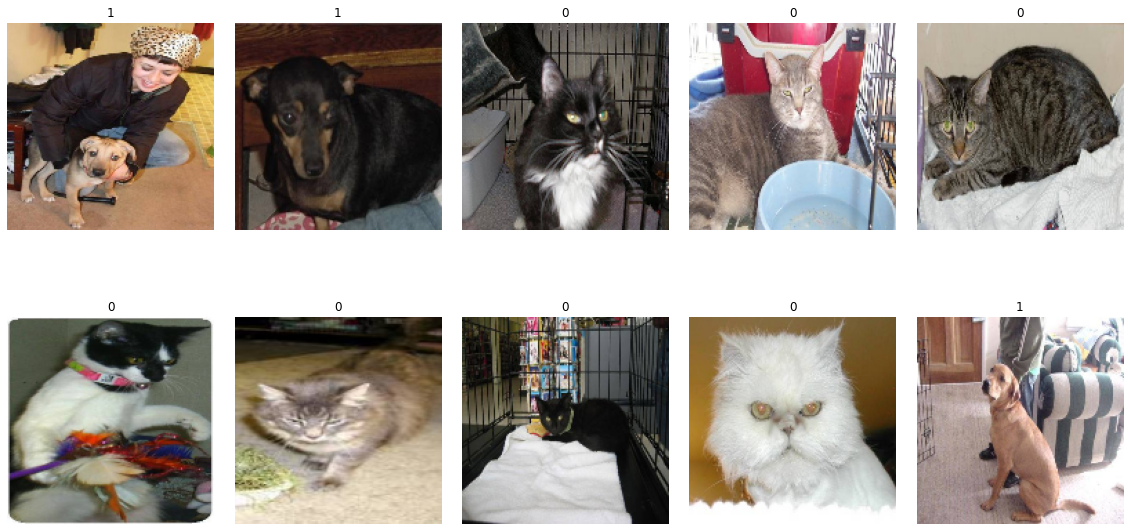

In [89]:
plot_images(X_train_small, y_train_small, 10)

skapa lämplig plot för att kontrollera att dataseten är balanserade

In [46]:
data = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_name = ["Small Data: train", "Small Data: val", "Small Data: test", "Tiny Data: train", "Tiny Data: val", "Tiny Data: test"]

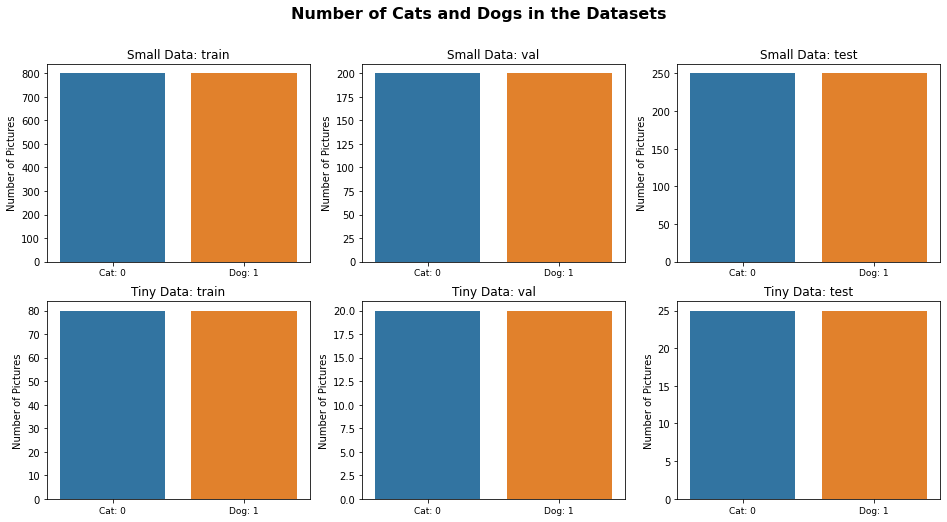

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of Pictures")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=9)

fig.suptitle("Number of Cats and Dogs in the Datasets", size=16, fontweight="bold");

skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

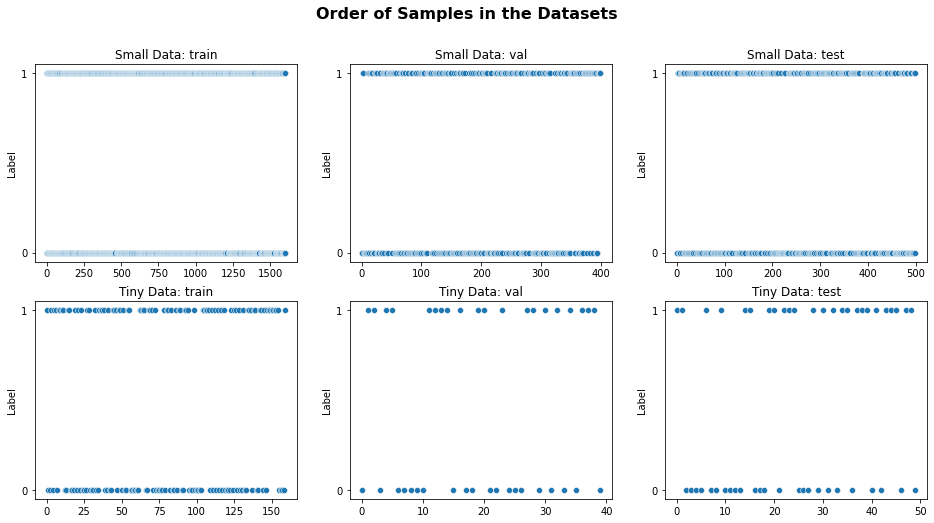

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Label")
    ax.locator_params(axis='y', nbins=2)
    ax.set_yticks([0, 1])

fig.suptitle("Order of Samples in the Datasets", size=16, fontweight="bold");

## 1. Bildbehandling (*)

Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

### a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [15]:
height_small = [X_train_small[i].shape[0] for i in range(len(X_train_small))]
width_small = [X_train_small[i].shape[1] for i in range(len(X_train_small))]

height_tiny = [X_train_tiny[i].shape[0] for i in range(len(X_train_tiny))]
width_tiny = [X_train_tiny[i].shape[1] for i in range(len(X_train_tiny))]

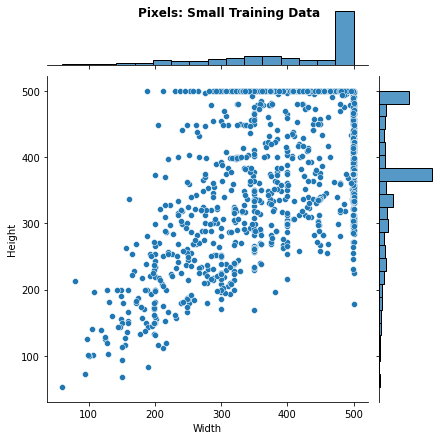

In [16]:
fig = sns.jointplot(x=width_small, y=height_small)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Small Training Data", size=12, fontweight="bold");

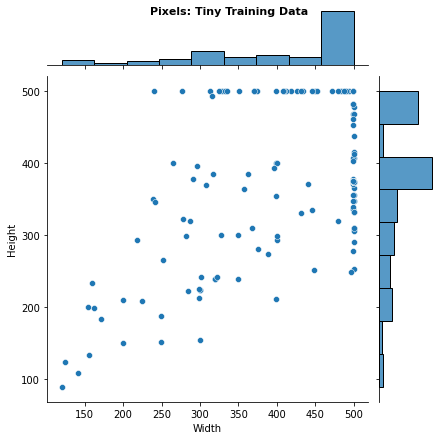

In [17]:
fig = sns.jointplot(x=width_tiny, y=height_tiny)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Tiny Training Data", size=11, fontweight="bold");

### b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver slänga bilder. Hur kommer du fram till ditt val?

In [34]:
resized = cv2.resize(X_train_small[497], (150, 150)) 
resized = resized.flatten()

In [42]:
resized2 = cv2.resize(X_train_small[19], (150, 150)) 
resized2 = resized2.flatten()

In [35]:
not_resized = X_train_small[497].flatten()

In [43]:
not_resized2 = X_train_small[19].flatten()

In [45]:
entropy(not_resized2)

7.59491417150576

In [46]:
entropy(resized2)

7.5908248058855365

In [36]:
entropy(resized)

7.872046770617287

In [37]:
entropy(not_resized)

7.876836751249844

In [30]:

for i in range(len(X_train_small)):
    shape1 = X_train_small[i].shape[0]
    shape2 = X_train_small[i].shape[1]
    if shape1 < 100 and shape2 < 100: 
        print(i)


291
497


In [40]:
for i in range(len(X_train_small)):
    shape1 = X_train_small[i].shape[0]
    shape2 = X_train_small[i].shape[1]
    if shape1 > 490 and shape2 > 490: 
        print(i)

19
124
137
160
171
182
186
201
217
327
500
613
626
779
811
975
994
1190
1223
1296


In [32]:
X_train_small[497].shape

(53, 59, 3)

In [41]:
X_train_small[19].shape

(500, 499, 3)

### c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande struktur:

(samples, row, cols, color_channels)

In [60]:
def resize_images(data, shape):
    data_resized = [cv2.resize(data[i], shape) for i in range(len(data))]
    data_resized = np.asarray(data_resized)
    return data_resized

In [61]:
X_train_small = resize_images(X_train_small, (150, 150))
X_val_small = resize_images(X_val_small, (150, 150))
X_test_small = resize_images(X_test_small, (150, 150))
X_train_tiny = resize_images(X_train_tiny, (150, 150))
X_val_tiny = resize_images(X_val_tiny, (150, 150))
X_test_tiny = resize_images(X_test_tiny, (150, 150))

print(X_train_small.shape, X_val_small.shape, X_test_small.shape, X_train_tiny.shape, X_val_tiny.shape, X_test_tiny.shape)

(1600, 150, 150, 3) (400, 150, 150, 3) (500, 150, 150, 3) (160, 150, 150, 3) (40, 150, 150, 3) (50, 150, 150, 3)


Visualisera därefter ett par styckena bilder.

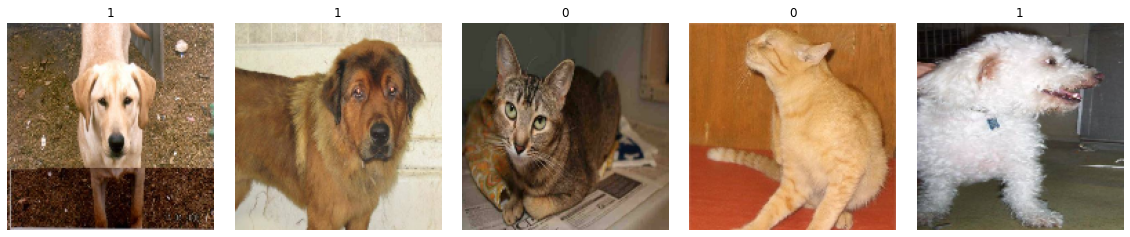

In [93]:
plot_images(X_train_small, y_train_small, 5, random_sample=True)

### d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar vilka parametrar du valt för augmenteringen?

In [62]:
print(f"{X_train_small.min()=}, {X_train_small.max()=}")
scaled_X_train_small = X_train_small.astype("float32") / 255
scaled_X_val_small = X_test_small.astype("float32") / 255
print(f"{scaled_X_train_small.min()=}, {scaled_X_train_small.max()=}")

X_train_small.min()=0, X_train_small.max()=255
scaled_X_train_small.min()=0.0, scaled_X_train_small.max()=1.0


In [7]:
train_image_generator = ImageDataGenerator(
                        rotation_range=30,
                        shear_range=.2,
                        zoom_range=.2,
                        horizontal_flip=True, 
                        height_shift_range=.2, 
                        width_shift_range=.2)

val_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train_small, y_train_small, batch_size=32)
val_generator = val_image_generator.flow(X_val_small, y_val_small, batch_size=32)

## 2. Träna modeller (*)
### För uppgifterna nedan, jobba med dataseten en åt gången:

small:
- utan augmentering
- med augmentering

tiny (BONUS):
- utan augmentering
- med augmentering

### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

In [29]:
def CNN_model(input_shape, learning_rate=.001, drop_rate=.3, kernels=[32, 64, 128, 128]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name="CNN_model")

    # The convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, 
                            kernel_size=(3, 3), 
                            activation="relu", 
                            kernel_initializer="he_normal", 
                            input_shape=input_shape)
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["acc"])

    return model

model = CNN_model(input_shape=(150, 150, 3))
model.summary()   

2022-05-02 19:21:39.980785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0 

In [17]:
steps_per_epoch = len(X_train_small)//32
validation_steps = len(X_val_small)//32

steps_per_epoch, validation_steps

(50, 12)

In [21]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

model.fit(train_generator, 
         steps_per_epoch = steps_per_epoch, 
         epochs = 100, 
         callbacks = [early_stopper], 
         validation_data=val_generator, 
         validation_steps = validation_steps)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

### Additional Test

In [5]:
os.mkdir(f"experiment_small_data/test2")

In [12]:
used_data = []
for dataset in ["train", "val", "test"]:
    used_data.extend(os.listdir(f"experiment_small_data/{dataset}"))

In [17]:
used_data

['cat.8553.jpg',
 'dog.9469.jpg',
 'cat.5705.jpg',
 'dog.3178.jpg',
 'cat.4355.jpg',
 'dog.8993.jpg',
 'cat.3348.jpg',
 'cat.10179.jpg',
 'cat.1239.jpg',
 'dog.6799.jpg',
 'cat.10838.jpg',
 'cat.9842.jpg',
 'cat.7847.jpg',
 'dog.8944.jpg',
 'cat.12222.jpg',
 'dog.4429.jpg',
 'dog.3352.jpg',
 'cat.8023.jpg',
 'cat.7338.jpg',
 'dog.10744.jpg',
 'cat.4157.jpg',
 'cat.11071.jpg',
 'cat.5249.jpg',
 'cat.4143.jpg',
 'dog.239.jpg',
 'dog.10963.jpg',
 'dog.9870.jpg',
 'dog.1592.jpg',
 'dog.12190.jpg',
 'dog.10787.jpg',
 'cat.6783.jpg',
 'cat.7489.jpg',
 'cat.11887.jpg',
 'cat.8143.jpg',
 'cat.5301.jpg',
 'dog.7040.jpg',
 'cat.5315.jpg',
 'cat.3764.jpg',
 'cat.8631.jpg',
 'dog.371.jpg',
 'cat.11111.jpg',
 'dog.9737.jpg',
 'dog.7929.jpg',
 'cat.10596.jpg',
 'dog.3583.jpg',
 'cat.11878.jpg',
 'cat.1198.jpg',
 'dog.10195.jpg',
 'dog.2879.jpg',
 'dog.7530.jpg',
 'dog.7524.jpg',
 'dog.9509.jpg',
 'cat.1371.jpg',
 'dog.8171.jpg',
 'cat.5659.jpg',
 'dog.4011.jpg',
 'cat.4235.jpg',
 'dog.8818.jpg',
 'c

In [34]:
original_data = pd.DataFrame({"file_name" : os.listdir("original_data/train")})
data_to_sample_from = original_data[~original_data["file_name"].isin(used_data)]

data_to_sample_from["cat"] = data_to_sample_from["file_name"].str.contains("cat") 

cats = data_to_sample_from[data_to_sample_from["cat"] == True]
dogs = data_to_sample_from[data_to_sample_from["cat"] == False]
cats = random.sample(list(cats["file_name"]), 250)
dogs = random.sample(list(dogs["file_name"]), 250)

test_small2 = cats + dogs
len(test_small2)

/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_10367/2198617903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_sample_from["cat"] = data_to_sample_from["file_name"].str.contains("cat")


500

In [36]:
#for file_name in test_small2:
#    source_path = f"original_data/train/{file_name}"
#    target_path = f"experiment_small_data/test2/{file_name}"
#    shutil.copyfile(source_path, target_path)

In [38]:
X_test_small2, y_test_small2 = read_images("experiment_small_data/test2")

In [52]:
print(f"Any image both in test2 and training data? {any(sample in X_test_small2 for sample in X_train_small)}")
print(f"Any image both in test2 and validation data? {any(sample in X_test_small2 for sample in X_val_small)}")
print(f"Any image both in test2 and test data? {any(sample in X_test_small2 for sample in X_test_small)}")

Any image both in test2 and training data? False
Any image both in test2 and validation data? False
Any image both in test2 and test data? False


/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_10367/2217901113.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f"Any image both in test2 and training data? {any(sample in X_test_small2 for sample in X_train_small)}")
/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_10367/2217901113.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f"Any image both in test2 and validation data? {any(sample in X_test_small2 for sample in X_val_small)}")
/var/folders/1s/8yq58qp97_9c9z1bcxs9mf940000gn/T/ipykernel_10367/2217901113.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f"Any image both in test2 and test data? {any(sample in X_test_small2 for sample in X_test_small)}")


In [54]:
#pickle_file(X_test_small2, "X_test_small2")
#pickle_file(y_test_small2, "y_test_small2")

In [55]:
from keras.models import load_model
model = load_model('DogsVsCatsPredictor.h5')


2022-05-09 23:08:02.619081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [71]:

X_test_small_150 = resize_images(X_test_small, (150, 150))
scaled_X_test_small_150 = X_test_small_150.astype("float32") / 255

In [72]:
y_pred = model.predict(scaled_X_test_small_150)


In [104]:
scaled_X_test_small_150.shape

(500, 150, 150, 3)

In [73]:
y_pred = (y_pred > .5)*1

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def print_and_plot_results(y_true:np.ndarray, y_pred:np.ndarray, data_name:str) -> None:
    """
    Prints a classification report and plots a confusion matrix. 
    
    Parameters
    ----------
    y_true : pd.Series
        The real y-values.
    y_pred : np.ndarray
        The predicted y-values.
    model_name : str
        The name of the model.
    """

    classification_report_ = classification_report(y_true, y_pred)
    print(f"Classification Report for {data_name}: \n {classification_report_}")
    
    cm = confusion_matrix(y_true, y_pred)
    cm_fig = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"]).plot()
    _ = cm_fig.ax_.set(title=f"{data_name}: Results on Test Data")


Classification Report for Data With Augmentation: 
               precision    recall  f1-score   support

           0       0.94      0.79      0.86       250
           1       0.82      0.95      0.88       250

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500



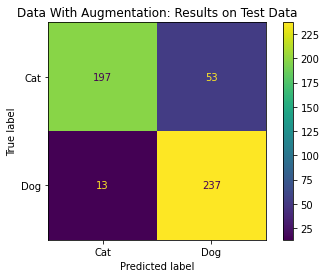

In [74]:
print_and_plot_results(y_test_small, y_pred, "Data With Augmentation")

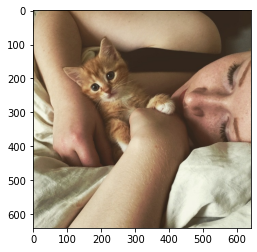

In [111]:
vifslan = plt.imread("Vifslan.jpeg")
plt.imshow(vifslan);

In [112]:
vifslan = cv2.resize(vifslan, (150, 150))
vifslan = vifslan.astype("float32") / 255
vifslan = np.expand_dims(vifslan, 0)
model.predict(vifslan)

array([[0.9840436]], dtype=float32)

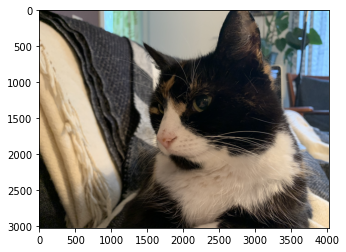

In [114]:
bubba = plt.imread("Bubba.jpg")
plt.imshow(bubba);

In [115]:
bubba = cv2.resize(bubba, (150, 150))
bubba = bubba.astype("float32") / 255
bubba = np.expand_dims(bubba, 0)
model.predict(bubba)

array([[0.07535964]], dtype=float32)